In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
cl_kadij = np.loadtxt("Cl_KadIJ.txt")
cl_lobith = np.loadtxt("Cl_Lobith.txt")
afvoer_lobith = np.loadtxt("afvoer_Lobith.txt")
stand_hvh = np.loadtxt("stand_HvH.txt")

In [3]:
print("shape van cl_kadij:", np.shape(cl_kadij))
print("shape van cl_lobith:", np.shape(cl_lobith))
print("shape van afvoer_lobith:", np.shape(afvoer_lobith))
print("shape van stand_hvh:", np.shape(stand_hvh))

shape van cl_kadij: (259633, 3)
shape van cl_lobith: (259633, 6)
shape van afvoer_lobith: (259633, 6)
shape van stand_hvh: (259633, 3)


In [4]:
print("eerste elementen:")
print(cl_kadij[1,:])
print(cl_lobith[1,:])
print(afvoer_lobith[1,:])
print(stand_hvh[1,:])

eerste elementen:
[  1.98201010e+07   1.00000000e+04   9.99999000e+02]
[  1.98201010e+07   1.00000000e+04   9.99999000e+02   7.67518000e+01
   9.99999000e+02   0.00000000e+00]
[  1.98201010e+07   1.00000000e+04   9.99999000e+02   9.99999000e+02
   9.99999000e+02   9.90000000e+01]
[  1.98201010e+07   1.00000000e+04  -2.80000000e+01]


In [5]:
usable_indices = (cl_kadij[:,2] != 999.999) & (cl_lobith[:,3] != 999.999) & (afvoer_lobith[:,3] != 999.999) & (stand_hvh[:,2] != 999.999)
print("Aantal metingen aanwezig in allen:", np.sum(usable_indices))

Aantal metingen aanwezig in allen: 225964


In [6]:
#check of data inderdaad allemaal voor zelfde date-time bij zelfde index staat:
if (np.sum(cl_kadij[:,:2] != cl_lobith[:,:2]) | np.sum(cl_lobith[:,:2] != afvoer_lobith[:,:2]) | np.sum(afvoer_lobith[:,:2] != stand_hvh[:,:2])):
    print("something is of")

In [7]:
#time_data = (cl_kadij[:,:2])[usable_indices]
time_data = ((np.loadtxt("Cl_KadIJ.txt",dtype=str))[:,:2])[usable_indices]
cl_kadij_data = (cl_kadij[:,2])[usable_indices]
cl_lobith_data = (cl_lobith[:,3])[usable_indices]
afvoer_lobith_data = (afvoer_lobith[:,3])[usable_indices]
stand_hvh_data = (stand_hvh[:,2])[usable_indices]
print("shapes:", np.shape(time_data), np.shape(cl_kadij_data), np.shape(cl_lobith_data), np.shape(afvoer_lobith_data), np.shape(stand_hvh_data))

shapes: (225964, 2) (225964,) (225964,) (225964,) (225964,)


In [8]:
#convert time_data into datetime format (this will take a while, several minutes!)
from datetime import datetime
datetime_data = np.array([]);
for row in range(len(time_data)):
    as_datetime = datetime.strptime(time_data[row,0] + " " + time_data[row,1], '%Y%m%d %H%M%S')
    datetime_data = np.append(datetime_data,as_datetime)

# Dagvoorspelling

Train een model om uit de data van een dag geleden (0:00 uur), de chloride bij Krimpen aan de IJssel te voorspellen.

Notes:
- modellen zijn nu simpel overgenomen van example Fedor, dus dit kan waarschijnlijk nog geoptimaliseerd worden
- eerste model neemt als input alleen afvoer en cl bij Lobith, en stand bij HvH
- tweede model neemt als vierde input parameter ook het cl van Krimpen ad IJssel van gisteren mee 
- data bevat gaten (en geen stuk lang genoeg om enkel dat te gebruiken), gaten zijn voor nu gewoon verwijderd, dit betekent vermoedelijk dat de voorspelling op data direct na een gat slechter is. 
- Andere ideeen ter verbetering zijn het toevoegen van een accumulatieve input van de afvoer van lobith, en het omzetten naar enkel een classificatie (onder 250 of boven etc.)

In [9]:
indices = (time_data[:,1] == "000000")
output_raw = cl_kadij_data[indices]
input_raw = np.transpose(np.vstack((cl_lobith_data, afvoer_lobith_data, stand_hvh_data)))
input_raw = input_raw[indices]
datetime_raw = datetime_data[indices]
print("input shape:", np.shape(input_raw))
print("output shape:", np.shape(output_raw))
print("datetime shape:", np.shape(datetime_raw))

input shape: (9445, 3)
output shape: (9445,)
datetime shape: (9445,)


In [10]:
#second option: also take the previous value into account 
input2_raw = np.transpose(np.vstack((cl_kadij_data, cl_lobith_data, afvoer_lobith_data, stand_hvh_data)));
input2_raw = input2_raw[indices]
print("input 2 shape:", np.shape(input2_raw))

input 2 shape: (9445, 4)


In [11]:
#normalize the data
import sklearn.preprocessing

def normalize_data(data):
    '''returns (scaled_data, scaler)'''
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    return (scaled_data, scaler)

In [12]:
output_scaled, output_scaler = normalize_data(output_raw.reshape(-1,1))
print("min output:", output_scaler.data_min_)
print("range output:", output_scaler.data_range_)

input_scaled, input_scaler = normalize_data(input_raw)
print("min input:", input_scaler.data_min_)
print("range input:", input_scaler.data_range_)

input2_scaled, input2_scaler = normalize_data(input2_raw) 
print("min input 2:", input2_scaler.data_min_)
print("range input 2:", input2_scaler.data_range_)

min output: [ 22.]
range output: [ 2247.]
min input: [  35.8669  789.605  -136.    ]
range input: [   384.1331  11095.395     374.    ]
min input 2: [  22.       35.8669  789.605  -136.    ]
range input 2: [  2247.        384.1331  11095.395     374.    ]


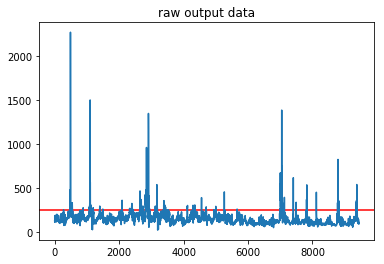

In [13]:
plt.axhline(y=250,color='red')
plt.title("raw output data")
plt.plot(output_raw);

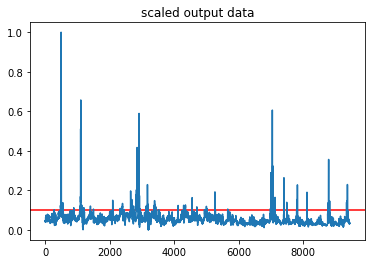

In [14]:
yline = output_scaler.transform(np.ones((1,1)) * 250)
plt.axhline(y=yline,color='red')
plt.title("scaled output data")
plt.plot(output_scaled);

In [15]:
#note that there may be gaps, so let's find those if they exist
from datetime import timedelta

def delete_gaps(datetimes, desired_delta, input_dat, output_dat):
    '''returns (input_nogaps, output_nogaps, datetimes_input)
    also transposes data such that input and output data returned are off by one timedelta'''
    datetime_diff = datetimes[1:] - datetimes[:-1]
    desired_diff = datetime_diff == desired_delta
    print("detected", np.sum(~desired_diff), "gaps")
    #print(np.where(desired_diff == False))
    
    input_nogaps = input_dat[np.append(desired_diff, np.array([False]))]
    datetimes_input = datetimes[np.append(desired_diff, np.array([False]))]
    output_nogaps = output_dat[np.insert(desired_diff, 0, False)]
    return (input_nogaps, output_nogaps, datetimes_input)


In [16]:
input_full , output_full, datetimes_input= delete_gaps(datetime_raw, timedelta(days=1), input_scaled, output_scaled)
input2_full , trash , trash2 = delete_gaps(datetime_raw, timedelta(days=1), input2_scaled, output_scaled)
print("final input shape:", np.shape(input_full))
print("final output shape:", np.shape(output_full))
print("final input 2 shape:", np.shape(input2_full))

detected 97 gaps
detected 97 gaps
final input shape: (9347, 3)
final output shape: (9347, 1)
final input 2 shape: (9347, 4)


In [17]:
#just split the data in three equal parts for training, test and validation
def split_data(data):
    '''returns (train_data, test_data, validate_data)'''
    size = int(len(data) / 3)
    train_data = data[:size]
    test_data = data[size:2*size]
    validate_data = data[2*size:]
    return (train_data, test_data, validate_data)

input_train , input_test, input_validate = split_data(input_full)
output_train, output_test, output_validate = split_data(output_full)
input2_train, input2_test, input2_validate = split_data(input2_full)
datetimes_train, datetimes_test, datetimes_validate = split_data(datetimes_input)

In [18]:
keras.callbacks.TensorBoard(
    log_dir='./logs', 
    histogram_freq=1, 
    batch_size=32, 
    write_graph=True, 
    write_grads=True, 
    write_images=True, 
    embeddings_freq=0, 
    embeddings_layer_names=None, 
    embeddings_metadata=None
);

In [19]:
model = keras.models.Sequential()
layer = keras.layers.LSTM(4,input_shape=(None,len(input_full[0])))
model.add(layer)
layer = keras.layers.Dense(1)
model.add(layer)
model.compile(loss='mean_squared_error', optimizer='adam')

In [20]:
model2 = keras.models.Sequential()
layer = keras.layers.LSTM(4,input_shape=(None, len(input2_full[0])))
model2.add(layer)
layer = keras.layers.Dense(1)
model2.add(layer)
model2.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
print("first model:")
model.summary()
print("\nsecond model:")
model2.summary()

first model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________

second model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(input_train[:,np.newaxis,:], output_train, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
7s - loss: 0.0017
Epoch 2/5
6s - loss: 0.0014
Epoch 3/5
5s - loss: 0.0014
Epoch 4/5
5s - loss: 0.0014
Epoch 5/5
5s - loss: 0.0014


In [23]:
history2 = model2.fit(input2_train[:,np.newaxis,:], output_train, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
6s - loss: 0.0016
Epoch 2/5
5s - loss: 0.0012
Epoch 3/5
5s - loss: 9.4089e-04
Epoch 4/5
5s - loss: 7.4302e-04
Epoch 5/5
5s - loss: 6.7523e-04


In [24]:
output_model = model.predict(input_test[:,np.newaxis,:])
output_model2 = model2.predict(input2_test[:,np.newaxis,:])

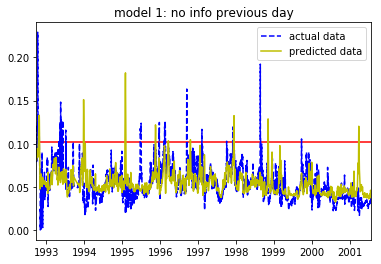

In [25]:
plt.axhline(y=yline,color='red')
plt.plot(datetimes_test, output_test,'b--',label='actual data')
plt.plot(datetimes_test, output_model, 'y',label='predicted data')
plt.title("model 1: no info previous day")
plt.xlim(datetimes_test[0], datetimes_test[-1])
plt.legend();

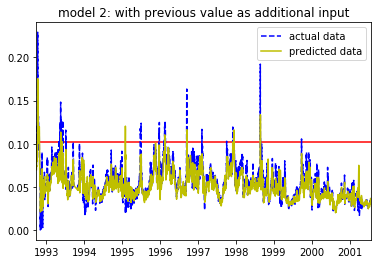

In [26]:
plt.axhline(y=yline,color='red')
plt.plot(datetimes_test, output_test,'b--',label='actual data')
plt.plot(datetimes_test, output_model2, 'y',label='predicted data')
plt.xlim(datetimes_test[0], datetimes_test[-1])
plt.title("model 2: with previous value as additional input")
plt.legend();

length of output: 3115


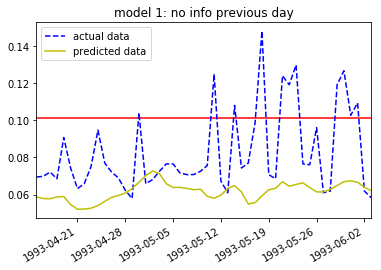

In [27]:
print("length of output:",len(output_model))

#kleiner stuk data helpt voor zichtbaarheid, verander selection om andere data the bekijken
selection = np.s_[200:250]
plt.axhline(y=yline,color='red')
plt.plot(datetimes_test[selection], output_test[selection],'b--',label='actual data')
plt.plot(datetimes_test[selection], output_model[selection], 'y',label='predicted data')
plt.xlim((datetimes_test[selection])[0], (datetimes_test[selection])[-1])
plt.gcf().autofmt_xdate()
plt.title("model 1: no info previous day")
plt.legend();

length of output: 3115


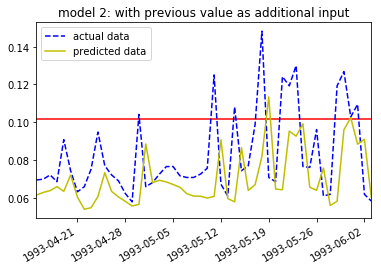

In [28]:
print("length of output:",len(output_model))

#kleiner stuk data helpt voor zichtbaarheid, verander selection om andere data the bekijken
selection = np.s_[200:250]
plt.axhline(y=yline,color='red')
plt.plot(datetimes_test[selection], output_test[selection],'b--',label='actual data')
plt.plot(datetimes_test[selection], output_model2[selection], 'y',label='predicted data')
plt.xlim((datetimes_test[selection])[0], (datetimes_test[selection])[-1])
plt.gcf().autofmt_xdate()
plt.title("model 2: with previous value as additional input")
plt.legend();

In [29]:
errors = np.abs(output_test - output_model)
MSE = errors ** 2
print("highest absolute SE:",np.max(MSE))
print("absolute MSE:",np.average(MSE))

actual_errors = errors * output_scaler.data_range_ + output_scaler.data_min_
MSE_actual = actual_errors ** 2
print("non-normalized highest absolute SE:",np.max(MSE_actual))
print("non-normalized absolute MSE:",np.average(MSE_actual))

rel_errors = actual_errors / (output_test*output_scaler.data_range_ + output_scaler.data_min_)
print("highest relative error:",np.max(rel_errors))
print("average relative error:",np.average(rel_errors))


highest absolute SE: 0.0266978231656
absolute MSE: 0.000349800092455
non-normalized highest absolute SE: 151436.055184
non-normalized absolute MSE: 3442.83661706
highest relative error: 6.63547505935
average relative error: 0.377331639003


In [30]:
errors = np.abs(output_test - output_model2)
MSE2 = errors ** 2
print("highest absolute SE:",np.max(MSE2))
print("absolute MSE:",np.average(MSE2))

actual_errors = errors * output_scaler.data_range_ + output_scaler.data_min_
MSE_actual = actual_errors ** 2
print("non-normalized highest absolute SE:",np.max(MSE_actual))
print("non-normalized absolute MSE:",np.average(MSE_actual))

rel_errors = actual_errors / (output_test*output_scaler.data_range_ + output_scaler.data_min_)
print("highest relative error:",np.max(rel_errors))
print("average relative error:",np.average(rel_errors))


highest absolute SE: 0.0121361131238
absolute MSE: 0.000132150646576
non-normalized highest absolute SE: 72651.0415339
non-normalized absolute MSE: 1901.33192348
highest relative error: 6.3136017605
average relative error: 0.288907058727


In [31]:
#vergelijk met basisvoorspelling, zelfde zoutgehalte als gisteren:
basic_error = np.abs(output_test[1:] - output_test[:-1])
MSE_basic = np.average(basic_error ** 2)
print("absolute MSE basic prediction method:", MSE_basic)
print("Prediction skill model 1:", 1 - np.average(MSE) / MSE_basic)
print("Prediction skill model 2:", 1 - np.average(MSE2) / MSE_basic)

absolute MSE basic prediction method: 8.35359818557e-05
Prediction skill model 1: -3.18741822008
Prediction skill model 2: -0.581960774755


# Uurvoorspelling

Voorspel de chloride m.b.v. de uurwaarden, 1 uur vooruit. Gebruik ook waarde 1 uur geleden als input (aangezien dit bij dagvoorspelling beter bleek)

In [32]:
hour_input_raw = np.transpose(np.vstack((cl_kadij_data, cl_lobith_data, afvoer_lobith_data, stand_hvh_data)))
print("shape raw input:", np.shape(hour_input_raw))
hour_output_raw = cl_kadij_data
print("shape raw output:", np.shape(hour_output_raw))
print("shape raw datetimes:", np.shape(datetime_data))

shape raw input: (225964, 4)
shape raw output: (225964,)
shape raw datetimes: (225964,)


In [33]:
hour_output_scaled, hour_output_scaler = normalize_data(hour_output_raw.reshape(-1,1))
print("min output:", hour_output_scaler.data_min_)
print("range output:", hour_output_scaler.data_range_)

hour_input_scaled, hour_input_scaler = normalize_data(hour_input_raw)
print("min input:", hour_input_scaler.data_min_)
print("range input:", hour_input_scaler.data_range_)

min output: [ 16.]
range output: [ 3490.]
min input: [  16.     33.1   780.08 -184.  ]
range input: [  3490.      386.9   11157.32    497.  ]


In [34]:
hour_input_full, hour_output_full, hour_datetimes_full = delete_gaps(datetime_data, timedelta(hours=1), hour_input_scaled, hour_output_scaled)
print("final input shape:", np.shape(hour_input_full))
print("final output shape:", np.shape(hour_output_full))

detected 461 gaps
final input shape: (225502, 4)
final output shape: (225502, 1)


In [35]:
hour_itest, hour_itrain, hour_ivalidate = split_data(hour_input_full)
hour_otest, hour_otrain, hour_ovalidate = split_data(hour_output_full)
hour_dttest, hour_dttrain, hour_dtvalidate = split_data(hour_datetimes_full)

In [36]:
hour_model = keras.models.Sequential()
layer = keras.layers.LSTM(4,input_shape=(None,len(hour_input_full[0])))
hour_model.add(layer)
layer = keras.layers.Dense(1)
hour_model.add(layer)
hour_model.compile(loss='mean_squared_error', optimizer='adam')

In [37]:
# will take about 140 seconds per epoch
hour_history = hour_model.fit(hour_itrain[:,np.newaxis,:], hour_otrain, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
137s - loss: 2.9113e-05
Epoch 2/5
135s - loss: 1.9987e-05
Epoch 3/5
137s - loss: 1.9503e-05
Epoch 4/5
136s - loss: 1.9187e-05
Epoch 5/5
133s - loss: 1.9158e-05


In [38]:
output_hourmodel = hour_model.predict(hour_itest[:,np.newaxis,:])

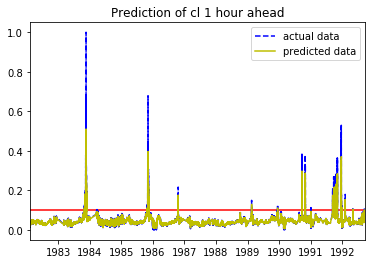

In [39]:
yline_hour = output_scaler.transform(np.ones((1,1)) * 250)
plt.axhline(y=yline_hour,color='red')
plt.plot(hour_dttest, hour_otest,'b--',label='actual data')
plt.plot(hour_dttest, output_hourmodel, 'y',label='predicted data')
plt.title("Prediction of cl 1 hour ahead")
plt.xlim(hour_dttest[0], hour_dttest[-1])
plt.legend();

length of output: 75167


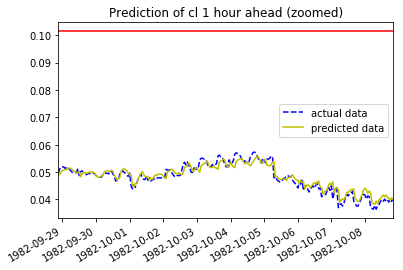

In [40]:
print("length of output:",len(output_hourmodel))

#kleiner stuk data helpt voor zichtbaarheid, verander selection om andere data the bekijken
selection = np.s_[200*24:210*24]
plt.axhline(y=yline_hour,color='red')
plt.plot(hour_dttest[selection], hour_otest[selection],'b--',label='actual data')
plt.plot(hour_dttest[selection], output_hourmodel[selection], 'y',label='predicted data')
plt.xlim((hour_dttest[selection])[0], (hour_dttest[selection])[-1])
plt.gcf().autofmt_xdate()
plt.title("Prediction of cl 1 hour ahead (zoomed)")
plt.legend();

In [41]:
errors = np.abs(hour_otest - output_hourmodel)
MSEhour = errors ** 2
print("highest absolute SE:",np.max(MSEhour))
print("absolute MSE:",np.average(MSEhour))

actual_errors = errors * hour_output_scaler.data_range_ + hour_output_scaler.data_min_
MSE_actual = actual_errors ** 2
print("non-normalized highest absolute SE:",np.max(MSE_actual))
print("non-normalized absolute MSE:",np.average(MSE_actual))

rel_errors = actual_errors / (hour_otest*hour_output_scaler.data_range_ + output_scaler.data_min_)
print("highest relative error:",np.max(rel_errors))
print("average relative error:",np.average(rel_errors))


highest absolute SE: 0.298035788267
absolute MSE: 0.000111918843677
non-normalized highest absolute SE: 3691330.78077
non-normalized absolute MSE: 1931.11715356
highest relative error: 6.05429959526
average relative error: 0.14342097199


In [42]:
basic_error = np.abs(hour_otest[1:] - hour_otest[:-1])
MSE_basic = np.average(basic_error ** 2)
print("absolute MSE basic prediction method:", MSE_basic)
print("Prediction skill hour model:", 1 - np.average(MSEhour) / MSE_basic)

absolute MSE basic prediction method: 5.19227729623e-05
Prediction skill hour model: -1.15548664472
